In [1]:
!pip install git+https://github.com/githubharald/CTCDecoder.git jiwer python-bidi arabic-reshaper

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/githubharald/CTCDecoder.git to /tmp/pip-req-build-zr8yi1h6
  Running command git clone -q https://github.com/githubharald/CTCDecoder.git /tmp/pip-req-build-zr8yi1h6
  Resolved https://github.com/githubharald/CTCDecoder.git to commit 6b5c3dd34944e5399a7308e241319b7f9c47e7c3


In [2]:
# Memilih GPU yang akan digunakan (contohnya: GPU #7)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import importlib
import pegon_utils
importlib.reload(pegon_utils)
from pegon_utils import PEGON_CHARS, CHAR_MAP, OCRDataset

In [4]:
for i in CHAR_MAP.keys():
    try:
        assert len(i) == 1
    except AssertionError:
        print(i)
        raise

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

from PIL import Image

import json
import os
import glob
import re
import datetime
import shutil
import pickle
import unicodedata

from functools import partial

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import random

import matplotlib.pyplot as plt

seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
model_name = 'ctc-xcxrnn'

In [7]:
os.makedirs(model_name, exist_ok=True)

In [8]:
importlib.reload(pegon_utils)
from pegon_utils import OCRDataset, QuranAnnotatedDataset
from torch.utils.data import random_split, ConcatDataset

pegon_synth_dataset = OCRDataset().load('/workspace/Dataset/Synthesized-split/metadata.json')

pegon_synth_dataset.char_map = CHAR_MAP

dataset_transforms = transforms.Compose([
    transforms.Resize((pegon_synth_dataset.avg_img_h, pegon_synth_dataset.avg_img_w)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
  ])

pegon_synth_dataset.transform = dataset_transforms

train_synth_dataset, val_synth_dataset = random_split(pegon_synth_dataset,
                                                      lengths=[round(len(pegon_synth_dataset) * frac) for frac in [0.7, 0.3]])

quran_train_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/traning',
                      image_transform=dataset_transforms)
quran_test_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/test',
                      image_transform=dataset_transforms)

train_dataset = ConcatDataset((train_synth_dataset, quran_train_dataset))
val_dataset = ConcatDataset((val_synth_dataset, quran_test_dataset))

In [9]:
import pdb

# Define the OCR model architecture
class XCXRNN(nn.Module):
    def __init__(self, num_classes, image_height, image_width, model_output_len,
                 dropout_rate, conv_channels, in_channels, lstm_layers,
                 lstm_size, kernel_sizes, paddings, bidirectional):
        super(self.__class__, self).__init__()

        self.model_output_len = model_output_len
        self.image_height = image_height
        self.image_width = image_width
        self.conv_channels = conv_channels
        self.paddings = paddings
        self.kernel_sizes = kernel_sizes
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.in_channels = in_channels
        
        # CNN part]
        input_channels = [self.in_channels] + conv_channels[:-1]
        output_channels = conv_channels
        assert len(input_channels) == len(output_channels) == len(paddings) == len(kernel_sizes)
        
        self.cnn = nn.Sequential(
            *(nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                      padding=padding, kernel_size=kernel_size) \
              for in_ch, out_ch, padding, kernel_size in zip(input_channels, output_channels,
                                                           paddings, kernel_sizes)))
        
        _, self.ft_channels, self.ft_height, self.ft_width = self.cnn(torch.randn(1, in_channels, self.image_height, self.image_width)).shape

        # first dense
        self.fc1 = nn.Linear(in_features=self.ft_channels * self.ft_height,
                             out_features=self.ft_channels)
        self.dropout = nn.Dropout(dropout_rate)

        # RNN part
        
        self.rnn = nn.LSTM(input_size=self.ft_channels, hidden_size=lstm_size,
                           num_layers=lstm_layers,
                           bidirectional=bidirectional, batch_first=True)

        self.fc2 = nn.Linear(in_features=(2 if bidirectional else 1)*lstm_size, out_features=num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = F.relu(x)
        
        x = F.interpolate(x, size=(self.ft_height, self.model_output_len), mode='bilinear', align_corners=False)

        x = x.permute(0, 3, 1, 2).reshape(x.shape[0],
                                          x.shape[3],
                                          x.shape[1] * x.shape[2])

        x = self.fc1(x)
        x = self.dropout(x)
        x, _ = self.rnn(x)
        x = self.fc2(x)
        x = x.log_softmax(2)
        return x

In [10]:
importlib.reload(pegon_utils)
from pegon_utils import model_length

model = XCXRNN(num_classes=len(CHAR_MAP),
               in_channels=3,
               image_height=pegon_synth_dataset.avg_img_h,
               image_width=pegon_synth_dataset.avg_img_w,
               model_output_len=model_length(b=2,c=100)(pegon_synth_dataset.max_seq_len),
               dropout_rate=0,
               conv_channels=[16, 16, 32, 32, 64],
               kernel_sizes=[3, 5, 5, 3, 3],
               paddings=[0] * 5,
               lstm_size=256,
               lstm_layers=2,
               bidirectional=True)

In [11]:
importlib.reload(pegon_utils)
from pegon_utils import CTCTrainer, FocalCTCLoss

# Train the model
trainer = CTCTrainer(model=model,
                     max_norm=1.0,
#                      lr=1e-3,
                     optimizer=optim.AdamW(model.parameters(), lr=1e-3),
                     batch_size=64,
#                      criterion=FocalCTCLoss(zero_infinity=True,
#                                             alpha=0.25,
#                                             gamma=0.75),
                     dataset=train_dataset)

In [12]:
assert trainer.model(train_dataset[0][0].unsqueeze(0).to(trainer.device)).shape[-1] == len(CHAR_MAP)

In [13]:
timestamp = datetime.datetime.now()
print(timestamp)

2023-05-15 09:07:24.908835


In [14]:
trainer.train(num_epochs=10)

Epoch [1/10] | Batch [942/942] | Running Loss: 4056.5306: 100%|██████████| 942/942 [33:02<00:00,  2.10s/it]
Epoch [2/10] | Batch [942/942] | Running Loss: 3497.3911: 100%|██████████| 942/942 [32:49<00:00,  2.09s/it]
Epoch [3/10] | Batch [942/942] | Running Loss: 3697.6909: 100%|██████████| 942/942 [28:30<00:00,  1.82s/it]
Epoch [4/10] | Batch [942/942] | Running Loss: 3676.9519: 100%|██████████| 942/942 [20:40<00:00,  1.32s/it]
Epoch [5/10] | Batch [942/942] | Running Loss: 4266.1690: 100%|██████████| 942/942 [16:30<00:00,  1.05s/it]
Epoch [6/10] | Batch [942/942] | Running Loss: 3454.3437: 100%|██████████| 942/942 [22:03<00:00,  1.41s/it]
Epoch [7/10] | Batch [942/942] | Running Loss: 3285.0174: 100%|██████████| 942/942 [22:00<00:00,  1.40s/it]
Epoch [8/10] | Batch [942/942] | Running Loss: 3758.8179: 100%|██████████| 942/942 [16:05<00:00,  1.03s/it]
Epoch [9/10] | Batch [942/942] | Running Loss: 3412.0804: 100%|██████████| 942/942 [16:45<00:00,  1.07s/it]
Epoch [10/10] | Batch [942/9

Finished training!


XCXRNN(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc1): Linear(in_features=4864, out_features=64, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (rnn): LSTM(64, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=512, out_features=80, bias=True)
)

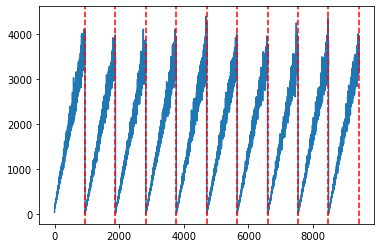

In [15]:
trainer.plot_history(path=f'{model_name}/{timestamp}.train.png')
trainer.save(f'{model_name}/{timestamp}.pt')

In [16]:
importlib.reload(pegon_utils)
from pegon_utils import CTCDecoder, BestPathDecoder, evaluate, plot_cer_wer

In [17]:
# dataloader = trainer.dataloader
dataloader = DataLoader(val_dataset,
                        batch_size=trainer.batch_size,
                        shuffle=True,
                        collate_fn=trainer.collate_fn)

In [18]:
# timestamp = '2023-05-02 15:56:58.754379'
# timestamp = '2023-05-02 20:53:48.971202'
model_path = f'{model_name}/{timestamp}.pt'

In [19]:
decoder = BestPathDecoder.from_path(model_path, CHAR_MAP, blank_char=PEGON_CHARS[0])
cers, wers = evaluate(decoder, dataloader)

 Example: 25327 | CER: 0.9634 | WER: 1.0000: 100%|██████████| 396/396 [06:43<00:00,  1.02s/it]


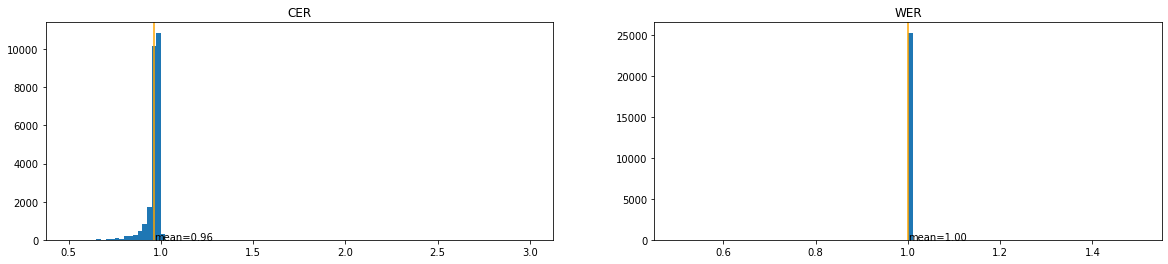

In [20]:
plot_cer_wer(cers, wers, path=f'{model_name}/{timestamp}.wer-cer.png')

/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 1748 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 1748 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


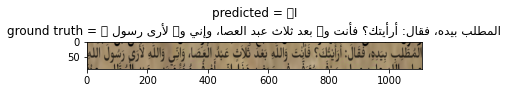

In [21]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display

to_arabic_display = lambda text: get_display(arabic_reshaper.reshape(text))
img, label = random.choice(val_dataset)
img, _, _ = dataloader.collate_fn([[img, label]])

gt = (''.join([PEGON_CHARS[l] for l in filter(lambda x:x!= 0, label)]))

predicted = decoder.infer(img.cuda())[0]

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]), cmap='gray'); plt.title(f'predicted = {to_arabic_display(predicted)}\nground truth = {to_arabic_display(gt)}'); plt.show()

In [22]:
import importlib
import pegon_utils
importlib.reload(pegon_utils)
from pegon_utils import FilenameOCRDataset, PegonAnnotatedDataset

annotated_dataset = PegonAnnotatedDataset('/workspace/Dataset/pegon-ocr-patched',
                                          image_transform=dataset_transforms)

annotated_dataloader = DataLoader(annotated_dataset, shuffle=True,
                                  batch_size=trainer.batch_size,
                                  collate_fn=trainer.collate_fn)
cers, wers = evaluate(decoder, annotated_dataloader)

 Example: 1976 | CER: 1.0286 | WER: 1.0000: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


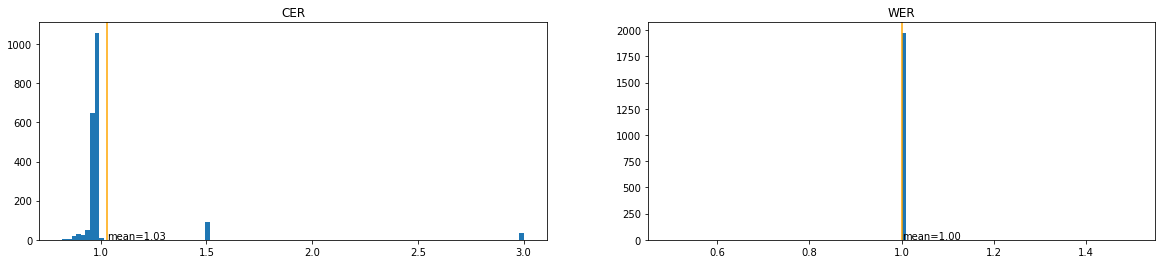

In [23]:
plot_cer_wer(cers, wers, path=f'{model_name}/{timestamp}.eval.wer-cer.png')

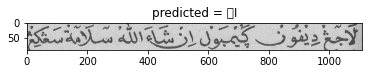

In [24]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display

to_arabic_display = lambda text: get_display(arabic_reshaper.reshape(text))
img, label, _ = dataloader.collate_fn([random.choice(annotated_dataset)])

predicted = decoder.infer(img.cuda())[0]

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]),cmap='gray'); plt.title(f'predicted = {to_arabic_display(predicted)}'); plt.show()